In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
dexcom = pd.read_csv('data/011/Dexcom_011.csv', parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'])
food_log = pd.read_csv('data/011/Food_Log_011.csv', parse_dates=['time','time_begin', 'time_end'])

C:\Users\rsl\AppData\Local\Temp\ipykernel_8372\2579186041.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  food_log = pd.read_csv('data/011/Food_Log_011.csv', parse_dates=['time','time_begin', 'time_end'])
C:\Users\rsl\AppData\Local\Temp\ipykernel_8372\2579186041.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  food_log = pd.read_csv('data/011/Food_Log_011.csv', parse_dates=['time','time_begin', 'time_end'])


In [3]:
demo = pd.read_csv('data/Demographics.csv')
demo

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [4]:
demo[demo['ID']==11] # This participant is prediabetic most likely.

,ID,Gender,HbA1c
11,11,MALE,6.0


In [5]:
# Clean Dexcom data and rename columns
dexcom_clean = dexcom[dexcom['Event Type'] == 'EGV'].copy()
dexcom_clean = dexcom_clean[['Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mg/dL)']]
dexcom_clean.columns = ['Timestamp', 'Glucose']
dexcom_clean.dropna(subset=['Timestamp', 'Glucose'], inplace=True)

# Categorize glucose readings based on 70–180 mg/dL range
def categorize_glucose(value):
    if value < 70:
        return 'Hypoglycemia (<70 mg/dL)'
    elif value <= 180:
        return 'Target Range (70–180 mg/dL)'
    else:
        return 'Hyperglycemia (>180 mg/dL)'

dexcom_clean['Category'] = dexcom_clean['Glucose'].apply(categorize_glucose)

# Count occurrences in each category
category_counts = dexcom_clean['Category'].value_counts().sort_index()
labels = category_counts.index
sizes = category_counts.values

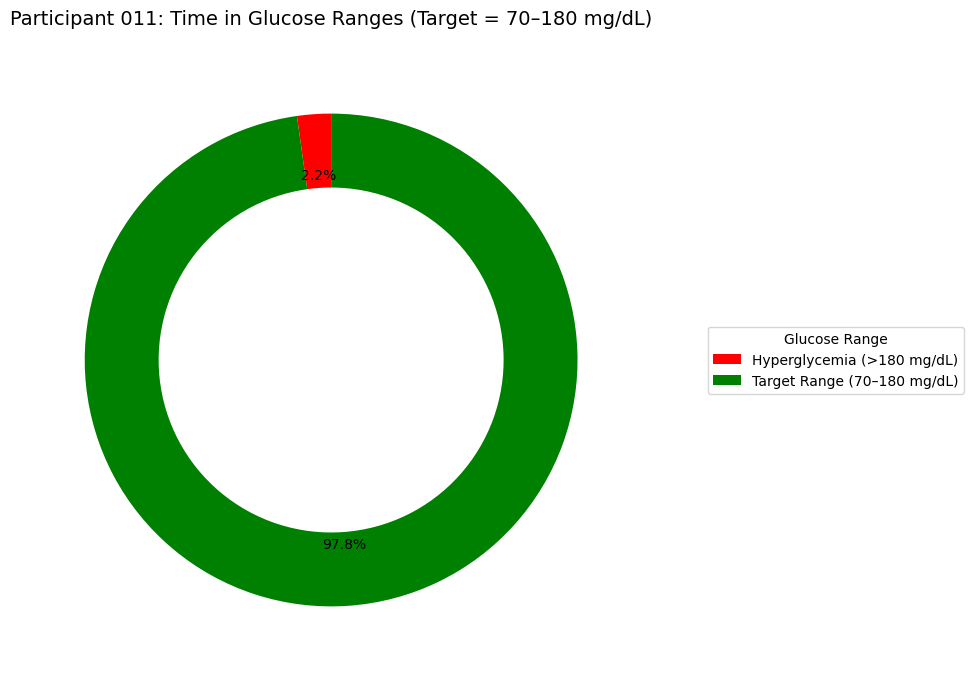

In [6]:
# Define custom colors for glucose categories
color_map = {
    'Target Range (70–180 mg/dL)': 'green',
    'Hyperglycemia (>180 mg/dL)': 'red',
    'Hypoglycemia (<70 mg/dL)': 'blue'
}

colors = [color_map[label] for label in labels]

# Create donut chart with custom colors
fig, ax = plt.subplots(figsize=(9, 8))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.3),
    pctdistance=0.75
)

# Add external legend
ax.legend(wedges, labels, title="Glucose Range", loc="center left", bbox_to_anchor=(1.1, 0.5))

# Title and layout
ax.set_title('Participant 011: Time in Glucose Ranges (Target = 70–180 mg/dL)', fontsize=14, pad=20)
plt.setp(autotexts, size=10, color="black")

# Save
# plt.savefig("glucose_time_in_range_donut_011.png", dpi=300, bbox_inches='tight')
plt.show()

Participant 011 is pretty good at staying at the target range for prediabetics.

Let's just pick two meals with differing calories in them and look at the two-hour before and after window (centered at the time of meal) of Participant 011's glucose levels.

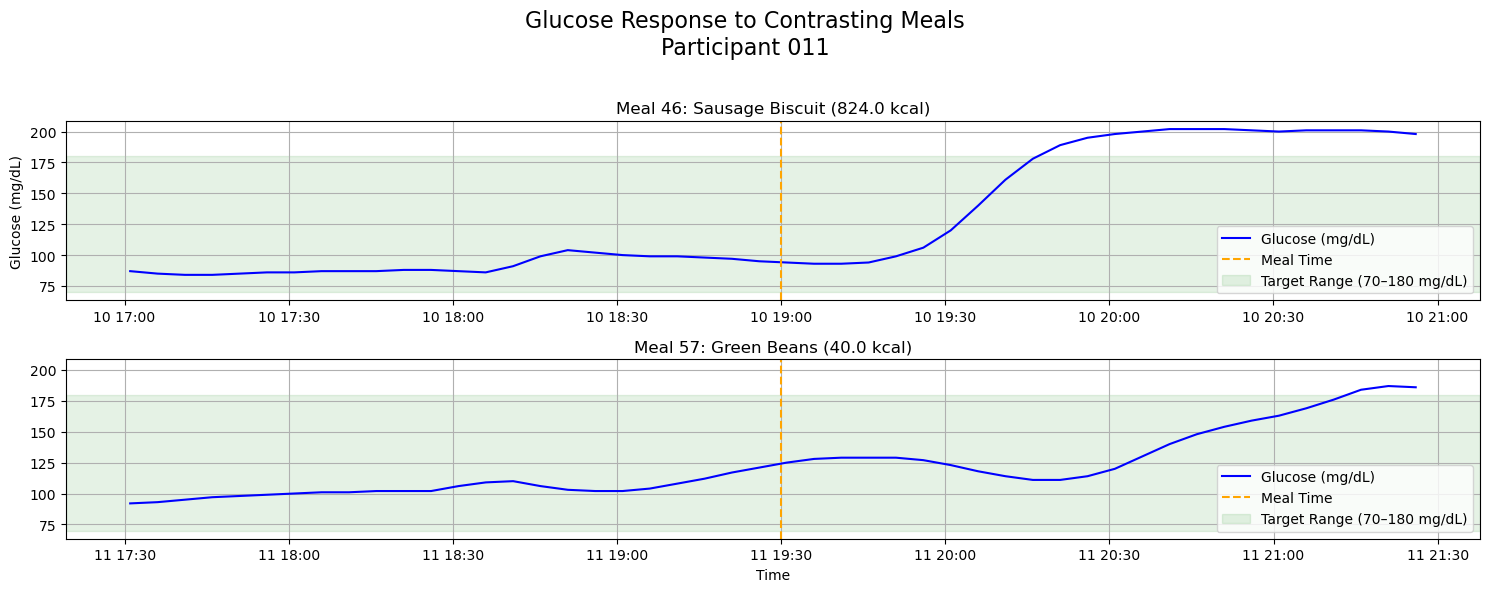

In [7]:
# Choose specific meal rows: Sausage Biscuit (46), Green Beans (57)
selected_meals = food_log.loc[[46, 57]]

# Set window around each meal
window = pd.Timedelta(hours=2)

fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharey=True)

for i, (idx, meal) in enumerate(selected_meals.iterrows()):
    start = meal['time_begin'] - window
    end = meal['time_begin'] + window
    meal_glucose = dexcom_clean[(dexcom_clean['Timestamp'] >= start) & (dexcom_clean['Timestamp'] <= end)]

    axes[i].plot(meal_glucose['Timestamp'], meal_glucose['Glucose'], color='blue', label='Glucose (mg/dL)')
    axes[i].axvline(meal['time_begin'], color='orange', linestyle='--', label='Meal Time')
    axes[i].axhspan(70, 180, color='green', alpha=0.1, label='Target Range (70–180 mg/dL)')
    axes[i].set_title(f"Meal {idx}: {meal['logged_food']} ({meal['calorie']} kcal)")
    axes[i].grid(True)
    axes[i].legend(loc='lower right')

# Add super-title and labels
fig.suptitle("Glucose Response to Contrasting Meals\nParticipant 011", fontsize=16)
plt.xlabel('Time')
axes[0].set_ylabel('Glucose (mg/dL)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig("glucose_meal_comparison_participant011.png", dpi=300)
plt.show()

Different meals tell a different blood sugar story.

Further exploratory routes:
- Need to see other participants' time-in-range.
- Meal Impact Analysis: Measure glucose rise in the two hours *after* each meal; `delta_glucose = max_glucose - baseline`.
- Time-in-Range over days.
- Mean Amplitude of Glycemic Excursions (MAGE): glucose variability scores. Could prepare these metrics per day and rank "good" vs. "bad" days
- Also need to look at ALL 16 participants. Glucose variability across all participants. HbA1c vs Time-in-Range. Cluster participants based on their glucose stats?